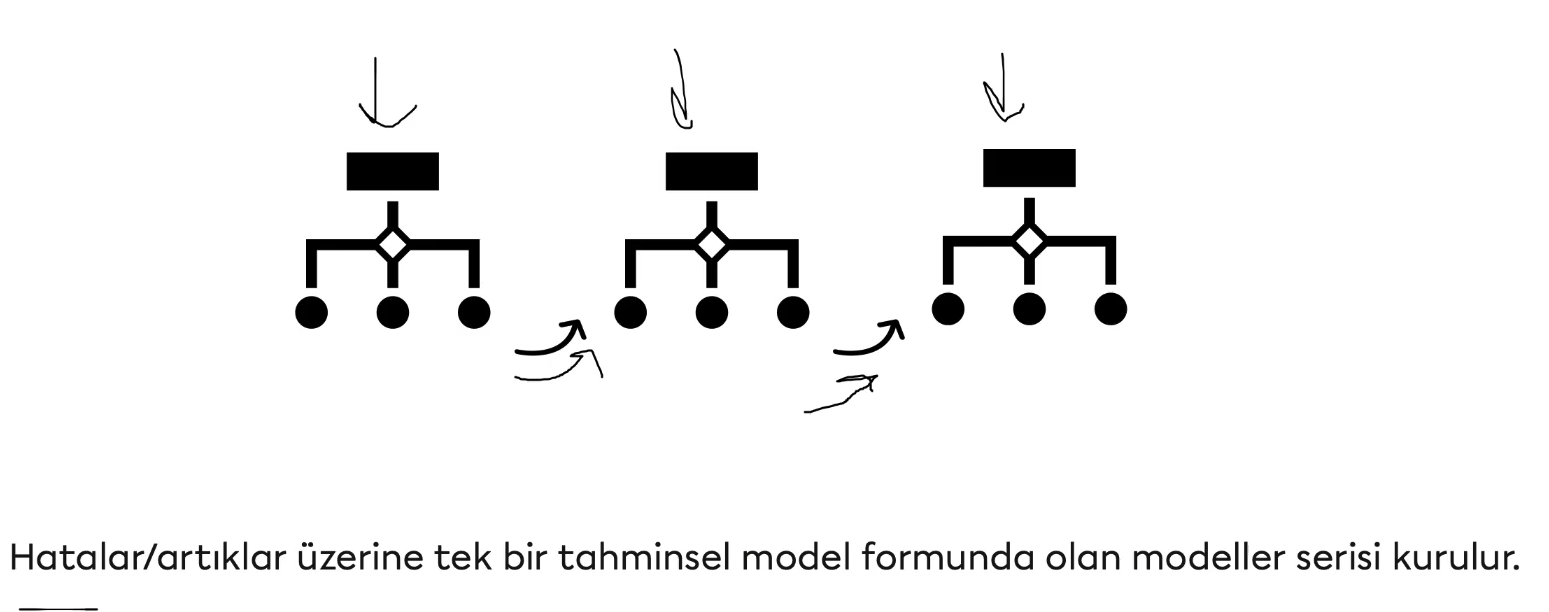

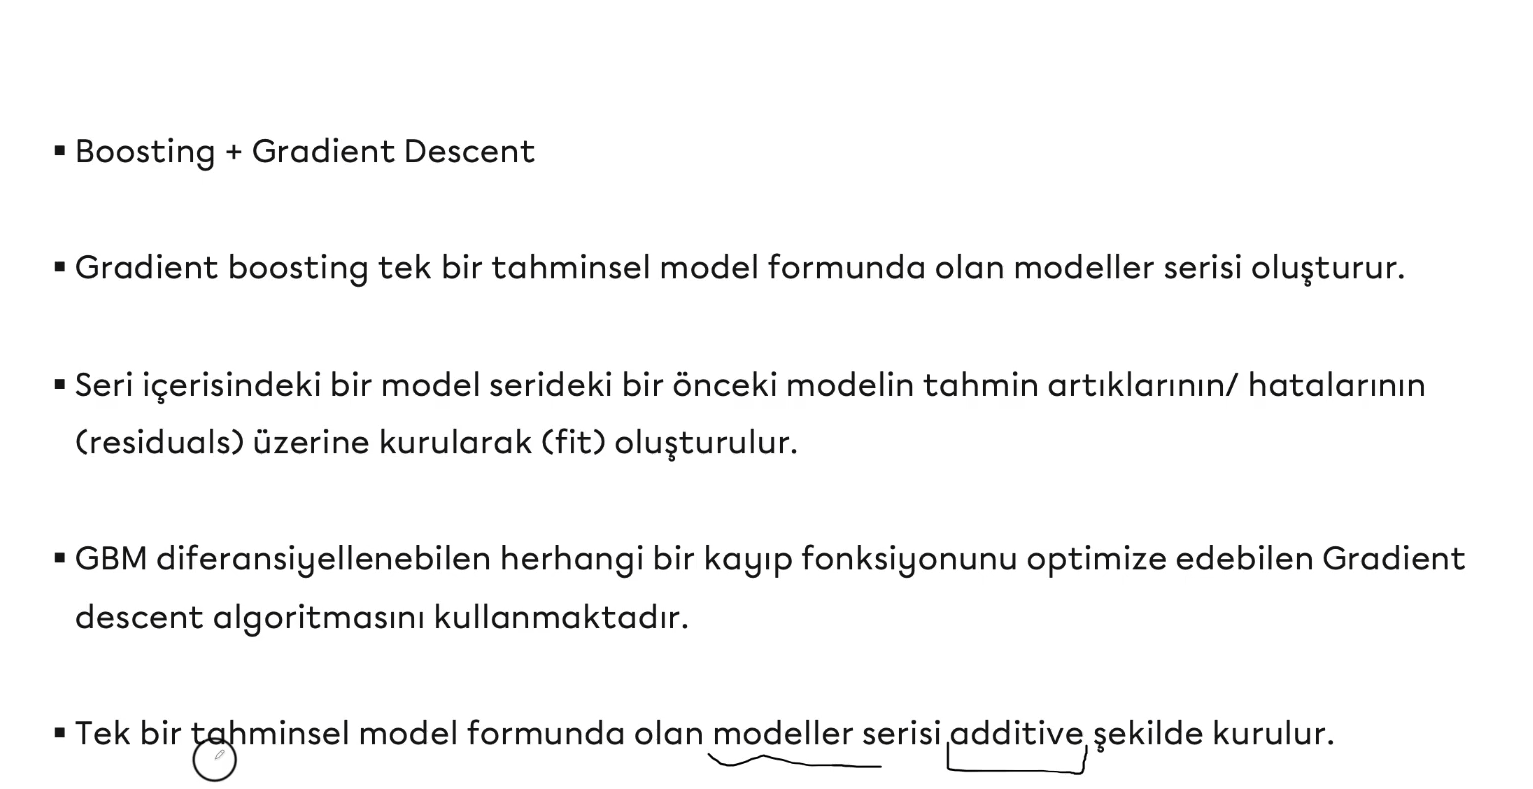

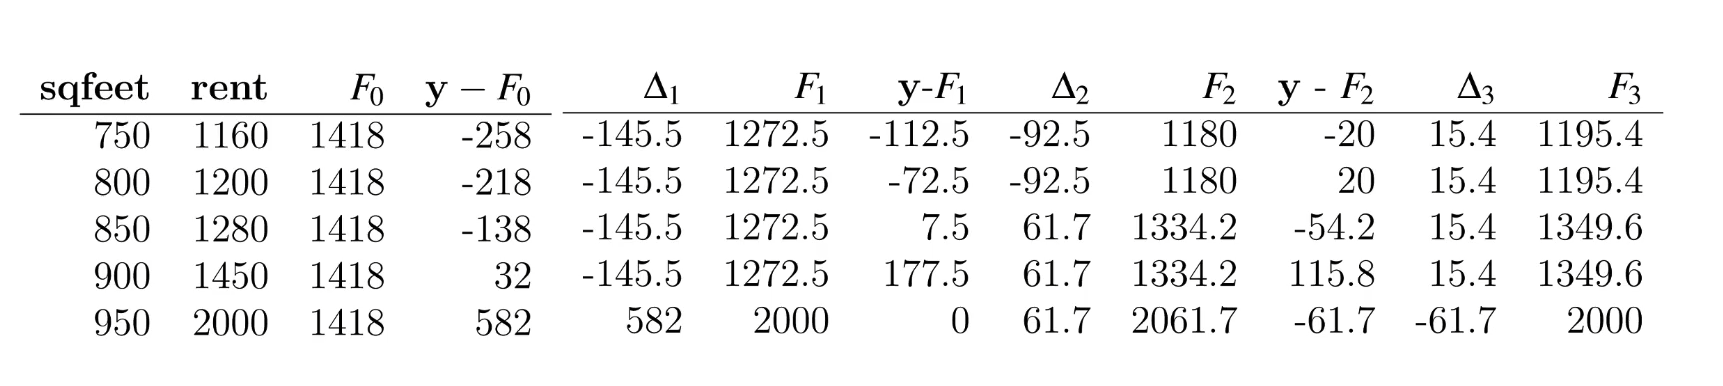

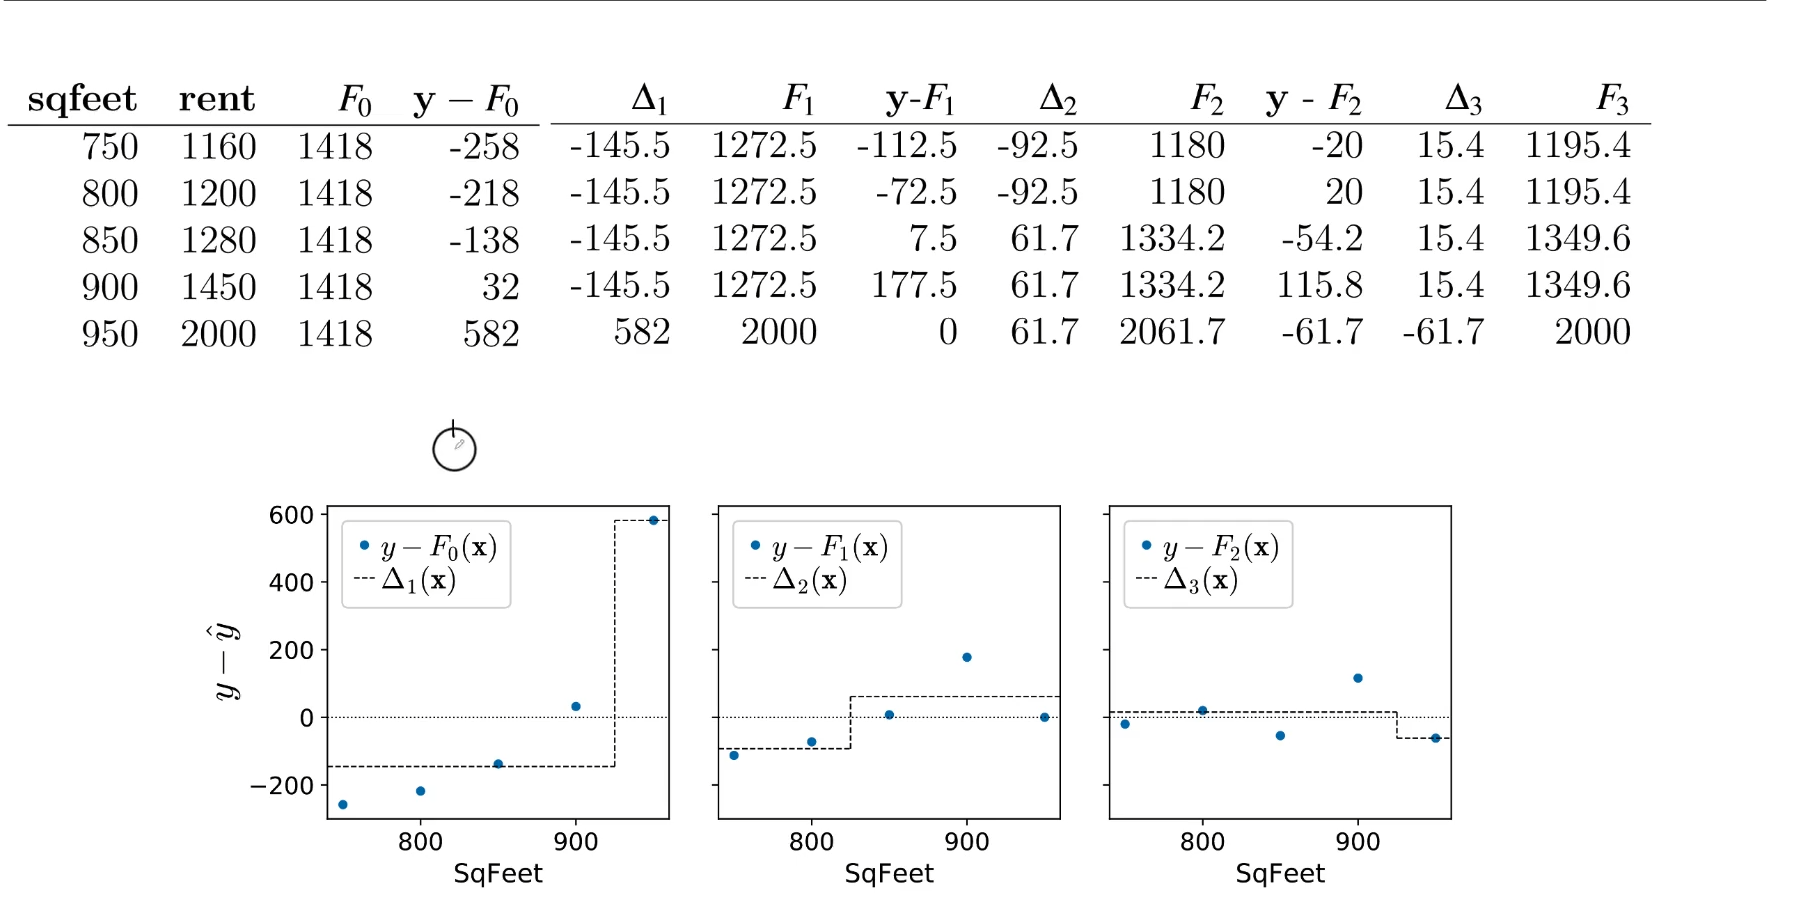

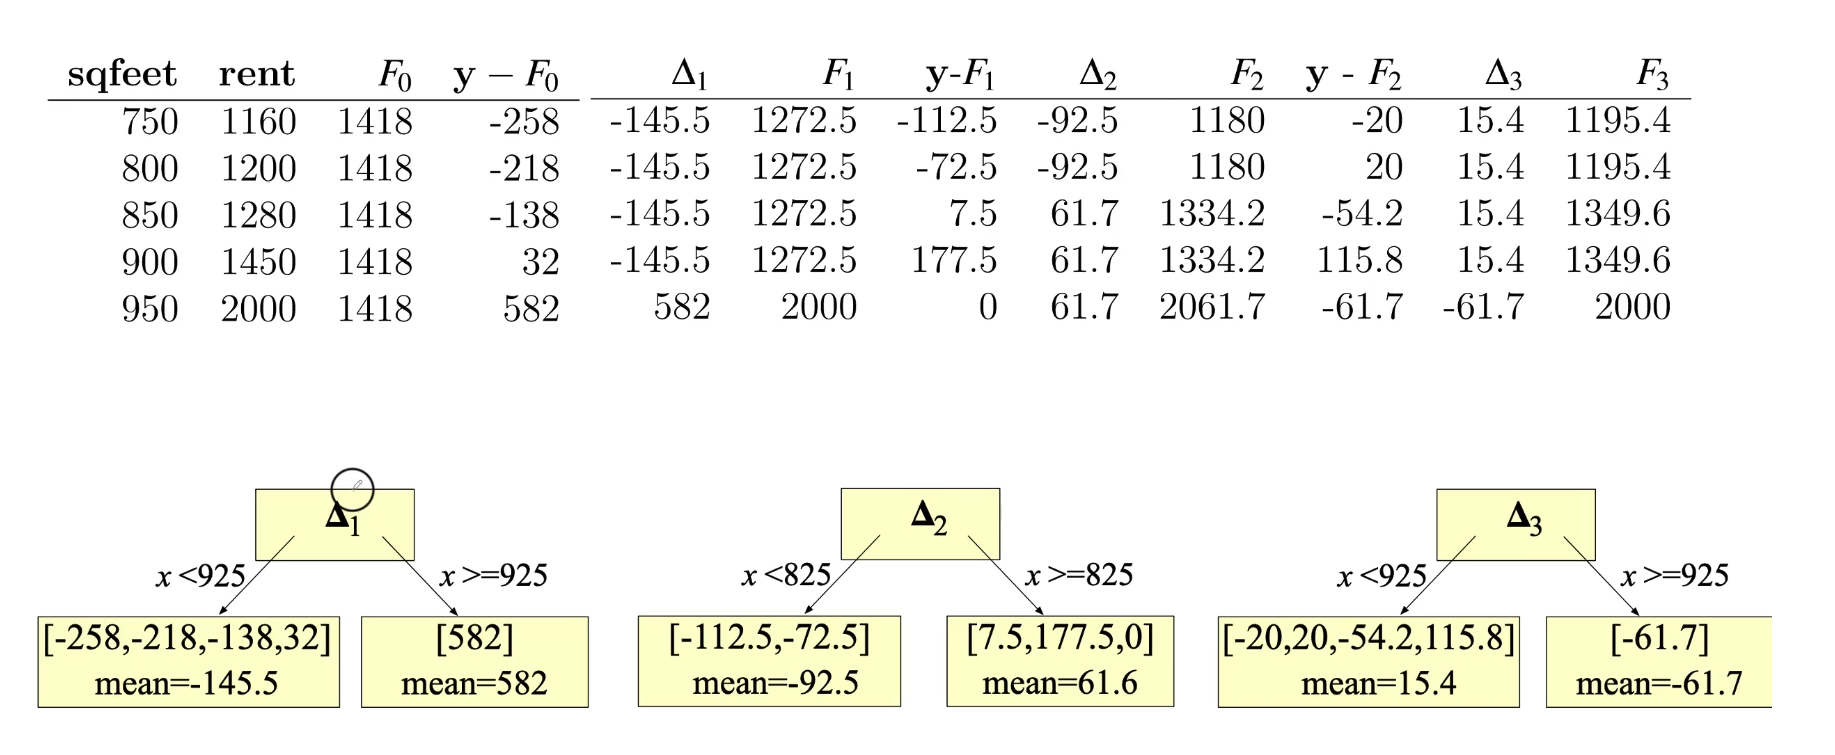

In [2]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
import warnings
import joblib 
import pydotplus 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier , export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,validation_curve
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier







In [3]:
df = pd.read_csv('../datasets/diabetes.csv')
df.head()
y=df["Outcome"]
X=df.drop(["Outcome"],axis=1)

In [4]:
gbm_model = GradientBoostingClassifier(random_state=17)

In [5]:
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [6]:
cv_result = cross_validate(gbm_model,X,y,cv=5,scoring=["accuracy","f1","roc_auc"])

In [7]:
cv_result['test_roc_auc'].mean()


0.8260164220824597

In [8]:
cv_result['test_f1'].mean()


0.634235802826363

In [9]:
cv_result['test_accuracy'].mean()


0.7591715474068416

In [10]:
gbm_params = {"learning_rate":[0.01,0.1],
              "max_depth":[3,8,10],
              "n_estimators":[100,500,1000],
              "subsample":[1,0.5,0.7],}

In [11]:
gbm_best_grid = GridSearchCV(gbm_model,gbm_params,cv=5,n_jobs=-1,verbose=True).fit(X,y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [12]:
gbm_best_grid.best_params_


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}

In [13]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_,random_state = 17).fit(X,y)


In [14]:
cv_result = cross_validate(gbm_final,X,y,cv=5,scoring=["accuracy","f1","roc_auc"])

In [15]:
cv_result['test_roc_auc'].mean()


0.8353221523410201

In [16]:
cv_result['test_f1'].mean()


0.6608461098755429

In [17]:
cv_result['test_accuracy'].mean()


0.7734912146676853

In [20]:

def val_curve_params_multi(model, X, y, param_grid, scoring="roc_auc", cv=10):
    """
    Birden fazla hiperparametre için validation_curve hesaplayan fonksiyon.

    Parameters:
        model: Makine öğrenmesi modeli (ör. DecisionTreeClassifier, RandomForestClassifier).
        X: Özellik matrisi (numpy array veya pandas DataFrame).
        y: Hedef değişkeni (numpy array veya pandas Series).
        param_grid: Hiperparametrelerin adlarını ve değerlerini içeren sözlük (dict).
        scoring: Değerlendirme metriği (str, varsayılan: "roc_auc").
        cv: Çapraz doğrulama kat sayısı (int, varsayılan: 10).

    Returns:
        scores: Tüm hiperparametreler için eğitim ve test skorlarının ortalamalarını içeren dict.
    """
    scores = {}

    for param_name, param_range in param_grid.items():
        print(f"Processing parameter: {param_name}")

        train_scores, test_scores = validation_curve(
            estimator=model,
            X=X,
            y=y,
            param_name=param_name,
            param_range=param_range,
            scoring=scoring,
            cv=cv
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        # Sonuçları kaydetme
        scores[param_name] = {
            "train_scores_mean": train_scores_mean,
            "test_scores_mean": test_scores_mean
        }

        # Her parametre için ayrı grafik oluşturma
        plt.figure(figsize=(8, 6))
        plt.plot(param_range, train_scores_mean, label="Training Score", color="b")
        plt.plot(param_range, test_scores_mean, label="Validation Score", color="g")
        plt.title(f"Validation Curve for {type(model).__name__}: {param_name}")
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.legend(loc="best")
        plt.grid()
        plt.show()

    return scores


Processing parameter: max_depth


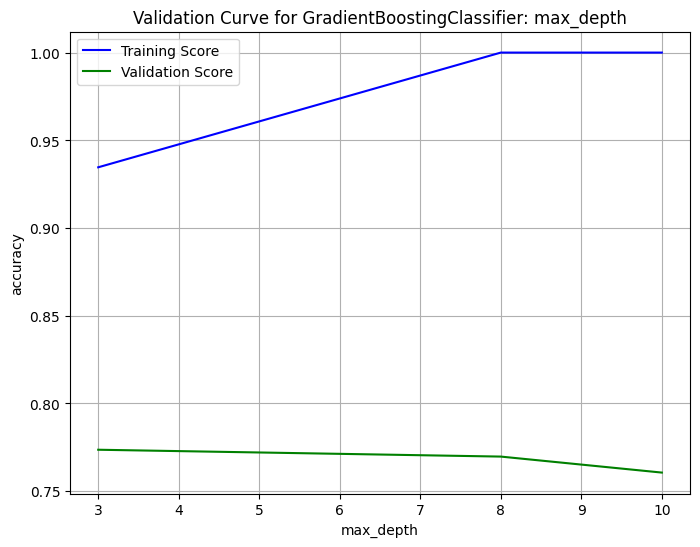

Processing parameter: learning_rate


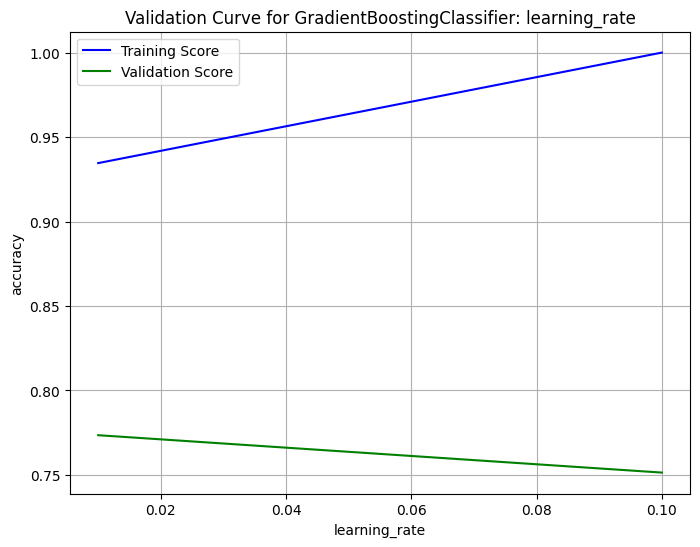

Processing parameter: n_estimators


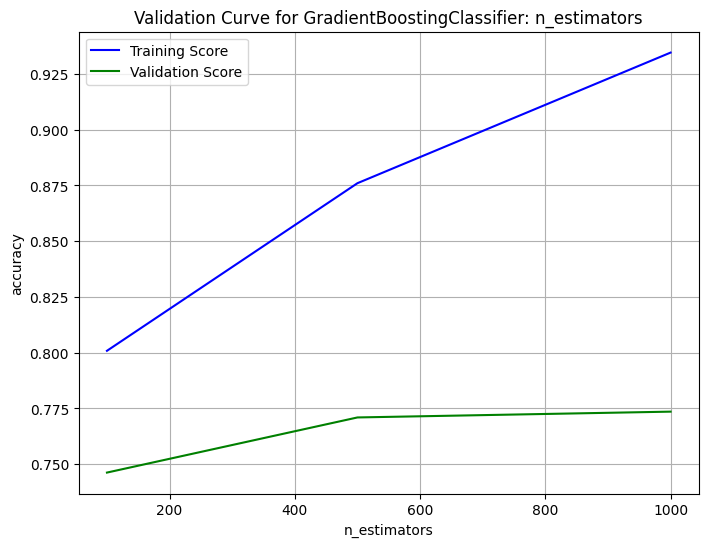

Processing parameter: subsample


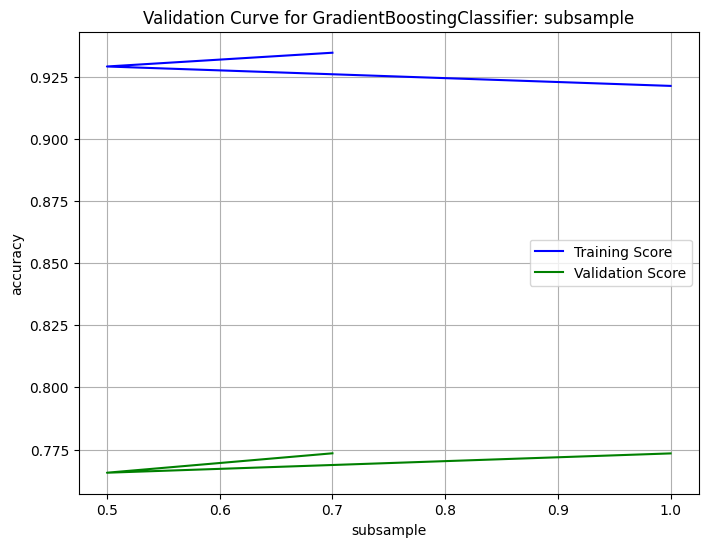

In [23]:
gbm_params = {
    "max_depth": [3, 8, 10],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 500, 1000],
    "subsample": [1, 0.5, 0.7]
}

# Fonksiyon çağrısı
scores = val_curve_params_multi(
    model=gbm_final,
    X=X,
    y=y,
    param_grid=gbm_params,
    scoring="accuracy",
    cv=5
)
